# FoodMini-Vision-Transformer

**Replicating a machine learning research paper** and creating a Vision Transformer (ViT) from scratch using PyTorch.

We'll then see how ViT, a state-of-the-art computer vision architecture, performs on our FoodVision Mini problem.




## Different section of machine learning research paper?

A machine learning research paper is a scientific paper that details findings of a research group on a specific area.

The contents of a machine learning research paper can vary from paper to paper but they generally follow the structure:

| **Section** | **Contents** |
| ----- | ----- |
| **Abstract** | An overview/summary of the paper's main findings/contributions. |
| **Introduction** | What's the paper's main problem and details of previous methods used to try and solve it. |
| **Method** | How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used? |
| **Results** | What are the outcomes of the paper? If a new type of model or training setup was used, how did the results of findings compare to previous works? (this is where **experiment tracking** comes in handy) |
| **Conclusion** | What are the limitations of the suggested methods? What are some next steps for the research community? |
| **References** | What resources/other papers did the researchers look at to build their own body of work? |
| **Appendix** | Are there any extra resources/findings to look at that weren't included in any of the above sections? |

## 0. Getting setup


In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the modular directory, download it from GitHub if it doesn't work
try:
    from modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the modular scripts
    print("[INFO] Couldn't find modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/rkstu/FoodMini-Vision-Transformer
    !mv FoodMini-Vision-Transformer/modular .
    !mv FoodMini-Vision-Transformer/helper_functions.py . # get the helper_functions.py script
    !rm -rf FoodMini-Vision-Transformer
    from modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'FoodMini-Vision-Transformer'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 15.14 KiB | 5.05 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
# setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get data

The whole goal of what we are doing is to replicate vit model for our FoodVision problem

To do that, we need to get data

downloading data

In [4]:
from torchvision import datasets
# Setup data directory
import pathlib
data_dir = pathlib.Path("../data")

In [5]:
data_dir

PosixPath('../data')

In [6]:
# Get training data
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              # transform=transforms.ToTensor(),
                              download=True)

# Get testing data
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             # transform=transforms.ToTensor(),
                             download=True)

100%|██████████| 4996278331/4996278331 [04:46<00:00, 17455209.68it/s]


Extracting ../data/food-101.tar.gz to ../data


In [7]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: ../data
    split=train

In [8]:
# View first sample (PIL Image format)
print(class_names[train_data[0][1]])
train_data[0][0]


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
class_names = ["pizza", "steak", "sushi"]

In [10]:
import random

# Setup data paths
data_path = data_dir / "food-101" / "images"
target_classes = class_names

# Change amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
amount_to_get = 0.1 # Getting 10% data

# Create function to separate a random amount of data
def get_subset(image_path=data_path,
               data_splits=["train", "test"],
               target_classes=class_names,
               amount=0.1,
               seed=42):
    random.seed(42)
    label_splits = {}

    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)

        # Apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits

label_splits = get_subset(amount=amount_to_get)

[INFO] Creating image split for: train...
[INFO] Getting random subset of 225 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 75 images for test...


In [11]:
# Create target directory path
target_dir_name = f"../data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: '../data/pizza_steak_sushi_10_percent'


In [12]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        # print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

In [13]:
# Check lengths of directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  import os
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(target_dir)

There are 2 directories and 0 images in '../data/pizza_steak_sushi_10_percent'.
There are 3 directories and 0 images in '../data/pizza_steak_sushi_10_percent/test'.
There are 0 directories and 31 images in '../data/pizza_steak_sushi_10_percent/test/sushi'.
There are 0 directories and 25 images in '../data/pizza_steak_sushi_10_percent/test/pizza'.
There are 0 directories and 19 images in '../data/pizza_steak_sushi_10_percent/test/steak'.
There are 3 directories and 0 images in '../data/pizza_steak_sushi_10_percent/train'.
There are 0 directories and 72 images in '../data/pizza_steak_sushi_10_percent/train/sushi'.
There are 0 directories and 78 images in '../data/pizza_steak_sushi_10_percent/train/pizza'.
There are 0 directories and 75 images in '../data/pizza_steak_sushi_10_percent/train/steak'.


In [14]:
# setup directory for training and testing imaes
from pathlib import Path
data = Path("data")

train_dir = data_dir / "pizza_steak_sushi_10_percent" / 'train'
test_dir = data_dir / "pizza_steak_sushi_10_percent" / 'test'

train_dir, test_dir

(PosixPath('../data/pizza_steak_sushi_10_percent/train'),
 PosixPath('../data/pizza_steak_sushi_10_percent/test'))

## 2. Create Datasets and DataLoader


In [15]:
!nvidia-smi

Thu Jan 25 13:18:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 2.1 Createa transformer

In [16]:
from torchvision import transforms

# Createa image
IMG_SIZE = 224  # comes from Table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### 2.2 Create transformer

In [17]:
# Change to Dataloaders with batch_size of 32 (the paper uses batch_size of 4096 but it may be tooo big for our hardware......can always scale up later)
from modular.data_setup import create_dataloaders
import os

BATCH_SIZE = 32
num_workers = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=num_workers
                                                                    )
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image from `train_dataloader`

In [18]:
import matplotlib.pyplot as plt

Image batch shape: torch.Size([32, 3, 224, 224]) 
Label batch shape: torch.Size([32]) 
sample image shape: (torch.Size([3, 224, 224]), torch.float32) 
sample label shape: (torch.Size([]), torch.int64)


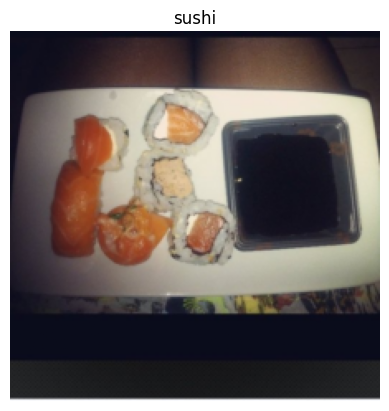

In [19]:
image_batch, label_batch = next(iter(train_dataloader))
print(f'Image batch shape: {image_batch.shape} \nLabel batch shape: {label_batch.shape} ')

# Taking one image from train_dataloder
sample_image, sample_label = image_batch[2], label_batch[2]
print(f'sample image shape: {sample_image.shape, sample_image.dtype} \nsample label shape: {sample_label.shape, sample_label.dtype}')

# Ploting sample image with its label as title
plt.imshow(sample_image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[sample_label.item()])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning resurch paper can be imtimidating

So in order to make it more understandable, we can break it down to smaller pieces
* **Inputs** - What goes into the model> (in out case, image tensor)
* **Outputs** -  What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks**  - A collection of layers.
* **Model (or architecture)** - A collection of blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)



### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time)



### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 Describes various equation
**Equation 1**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocod:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```




**Equation 2 & 3**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```



**Equation 4**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.
* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:
```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```


### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention


## 4. Equation 1: Split data into patches and creating the class, position and path embedding

Layers = input->funciton->output

What's the input shape?

What's the output shape



### 4.1 Calculte input and output shape

>**Equation 1**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

>**Equation 1**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = weight
* C = color channels
* P = patch size
* N = number od patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [20]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of pathces
number_of_patches  = (height * width) / (patch_size**2)
number_of_patches

196.0

In [21]:
# Input shape
embedding_layer_input_shape =  (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patch): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patch): (196.0, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

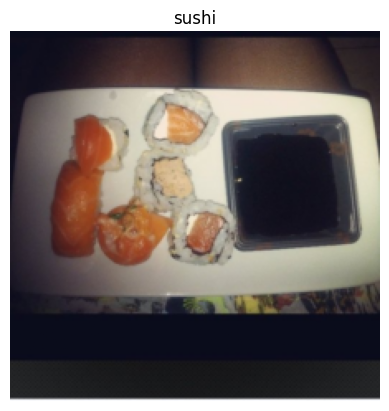

In [22]:
# View a single image
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(class_names[sample_label.item()])
plt.axis(False)

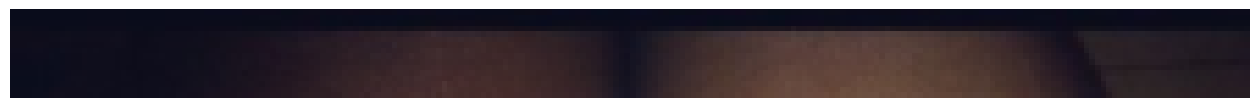

In [23]:
# Get the top row of the image
image_permuted = sample_image.permute(1, 2, 0) # Convert image color channels last (H, W, C)

# Index to plot the top row of pixels
path_size = 16
plt.figure(figsize=(path_size, path_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


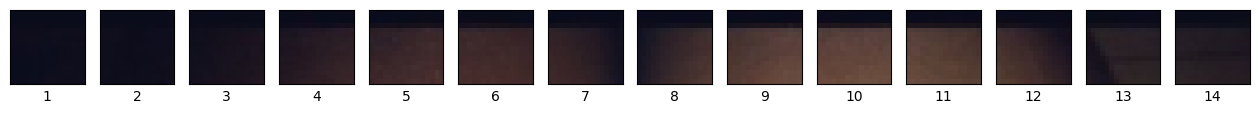

In [24]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / path_size
assert img_size % path_size == 0, "Image size must be divisible by path_size"
print(f'Number of patches per row: {num_patches}\nPatch size: {path_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column each path
                        sharex=True,
                        sharey=False,
                        figsize=(path_size, path_size))

# Iterare through number of pathces in the top row
for i, patch in enumerate(range(0, img_size, path_size)):
  axs[i].imshow(image_permuted[:path_size, patch:patch+path_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  # print(patch)

Number of patches per row: 14.0
Number of patches per Col: 14.0
Patch size: 16 pixels x 16 pixels


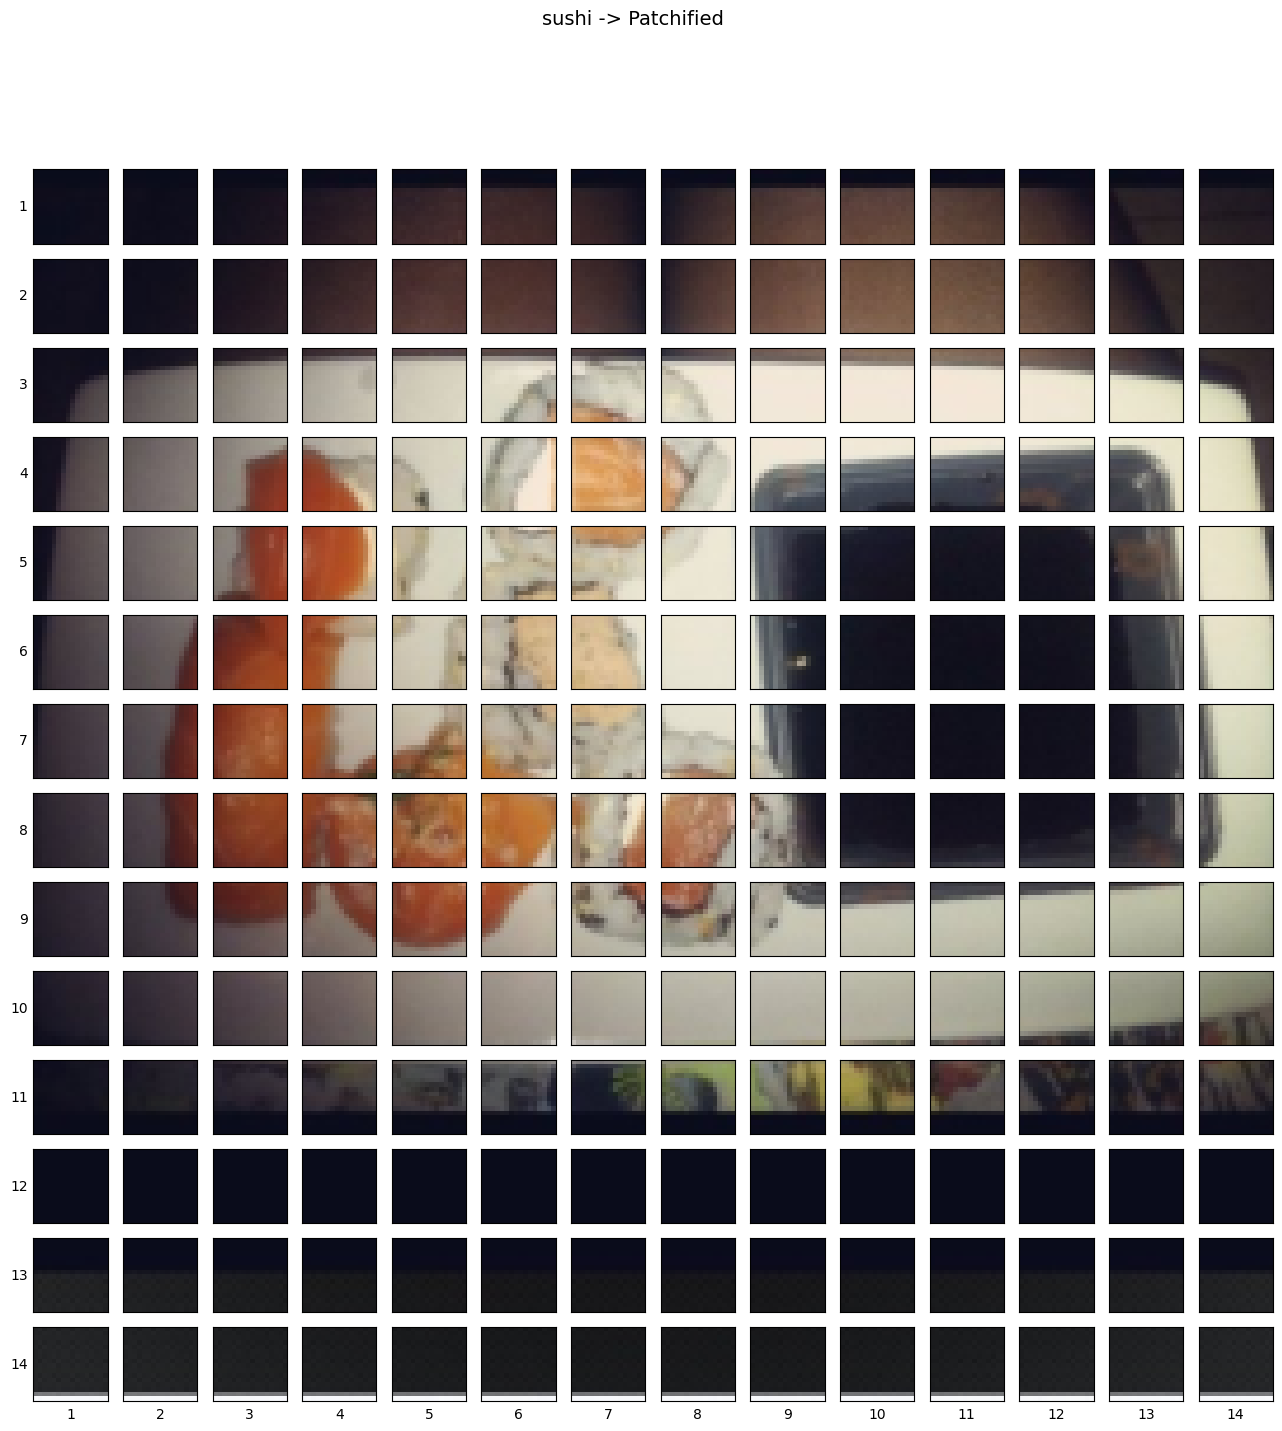

In [25]:
# Plot whole image as pathces
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / path_size
assert img_size % path_size == 0, "Image size must be divisible by path_size"
print(f'Number of patches per row: {num_patches}\nNumber of patches per Col: {num_patches}\nPatch size: {path_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # one row each path
                        ncols=img_size // patch_size, # one column each path
                        sharex=True,
                        sharey=False,
                        figsize=(path_size, path_size))

# Iterare through number of pathces in the top row
for i, patch_height in enumerate(range(0, img_size, path_size)):
  for j, patch_width in enumerate(range(0, img_size, path_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height+path_size, patch_width:patch_width+path_size, :]);

    # Setup label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()
  # setup a title for the plot
  fig.suptitle(f'{class_names[sample_label.item()]} -> Patchified', fontsize=14)

### 4.3 Creating image pathces and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.conv2d()` and setting the kernel size and stide parameters to `path_size`

In [26]:
# Create conv2d layer to turn image into patches of learnable features maps (embeddings)
from torch import nn

# Set the patchsize
patch_size = 16

# Create a conv2d layer with hyperparameters from ViT paper
conv2d = nn.Conv2d(in_channels=3, # color channels
                   out_channels=768, # D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

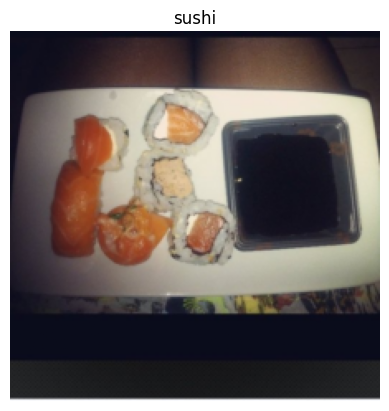

In [27]:
# View single image
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(class_names[sample_label.item()])
plt.axis(False);

In [28]:
# Pass the image though the convouational layer
image_out_of_conv = conv2d(sample_image.unsqueeze(dim=0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional features maps from indexes: [309, 626, 669, 541, 8]


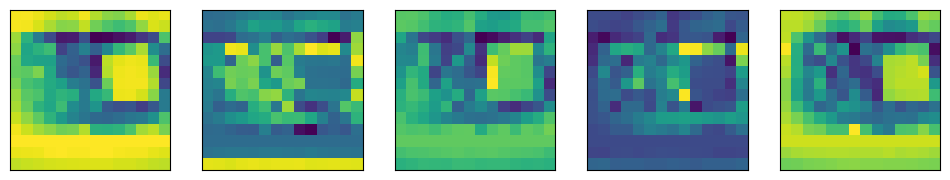

In [29]:
# Plot random convolutional feature  maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f'Showing random convolutional features maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [30]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map.shape, single_feature_map.requires_grad, single_feature_map.shape

(torch.Size([1, 14, 14]), True, torch.Size([1, 14, 14]))

 ### 4.4 Flattening the patch embeddings with `torch.nn.Flatten()`

 Right now we have a series of convolutional feature maps(patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input cretaria of out ViT Transformer Emcoder

In [31]:
print(f'{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]')

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Wnat: [batch_size, number_of_patches, embedding_dim]

In [32]:
result = torch.flatten(image_out_of_conv, start_dim=2, end_dim=3)


In [33]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattend image feature map shape: torch.Size([1, 768, 196])


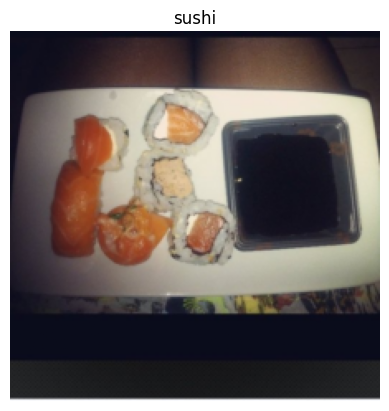

In [34]:
# Put everything together
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(class_names[sample_label.item()])
plt.axis(False)
print(f'Original image shape: {sample_image.shape}')

# Turn image into feature image
image_out_ofOconv = conv2d(sample_image.unsqueeze(dim=0)) # adding a batch dim
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature map
image_out_of_conv_flattend = flatten_layer(image_out_of_conv)
print(f'Flattend image feature map shape: {image_out_of_conv_flattend.shape}')

In [35]:
# Rearrange output of flattened layer
image_out_of_conv_flattend_permuted = image_out_of_conv_flattend.permute(0, 2, 1)
print(f'{image_out_of_conv_flattend_permuted.shape} -> (batch_size, patch_size, embedding_dim')

torch.Size([1, 196, 768]) -> (batch_size, patch_size, embedding_dim


In [36]:
image_out_of_conv_flattend.requires_grad

True

torch.Size([1, 196]) True


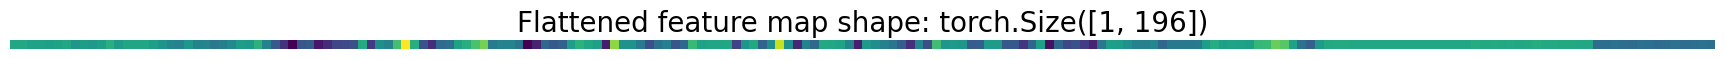

In [37]:
# Get a single flattend feature map
single_flattened_feature_map = image_out_of_conv_flattend_permuted[:, :, 0]
print(single_flattened_feature_map.shape, single_flattened_feature_map.requires_grad)

# Plot the flattend feature map visaully
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}', fontsize=20)
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparamters, such as channels, embedding dimension, path size,
3. Create a layer to turn image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the reuired output shape of the embeddings.

In [38]:
# 1. Creating
class PatchEmbedding(nn.Module):
  # 2. Create a conv2d layer with hyperparameters from ViT paper
  def __init__(self, in_channels:int=3, embedding_dim:int=768, patch_size:int=16):
    super().__init__()
    self.patch_size = patch_size
    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels, # color channels
                          out_channels=embedding_dim, # D size from Table 1
                          kernel_size=patch_size,
                          stride=patch_size,
                          padding=0)
    # 4. Flatten layer
    self.flatten_layer = nn.Flatten(start_dim=2,
                                    end_dim=3)
  # 5. Define foward
  def forward(self, x:torch.Tensor) -> torch.Tensor():
    # Create asserion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image size must be divisible by path_size, image shape: {image_resolution}, patch size: {self.patch_size}'
    return self.flatten_layer(self.patcher(x)).permute(0, 2, 1)


In [39]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through path embedding layer
print(f'Input image size: {sample_image.unsqueeze(dim=0).shape}') # adding a batch dim
patch_embedded_image = patchify(sample_image.unsqueeze(dim=0))
print(f'Output patch embeddings size: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embeddings size: torch.Size([1, 196, 768])


In [40]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token emebedding

Want to: prepend a learnable class token to start of the patch embedding.

In [41]:
patch_embedded_image

tensor([[[-0.0877,  0.0102, -0.0513,  ...,  0.0631, -0.0262,  0.0199],
         [-0.0916,  0.0084, -0.0506,  ...,  0.0623, -0.0291,  0.0249],
         [-0.1237,  0.0051, -0.0488,  ...,  0.0799, -0.0375,  0.0285],
         ...,
         [-0.3503,  0.0900, -0.3855,  ...,  0.1192,  0.0827,  0.0274],
         [-0.3609,  0.0878, -0.3867,  ...,  0.1260,  0.0821,  0.0347],
         [-0.3632,  0.0918, -0.3882,  ...,  0.1355,  0.0767,  0.0423]]],
       grad_fn=<PermuteBackward0>)

In [42]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [43]:
# Create class token embedding as a learnable parameters that shares the same size as the embedded dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [44]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [45]:
# Add the class token embedding to the front of the patch embedding
patch_embedding_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # number_of_patches dimension
print(patch_embedding_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedding_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0877,  0.0102, -0.0513,  ...,  0.0631, -0.0262,  0.0199],
         [-0.0916,  0.0084, -0.0506,  ...,  0.0623, -0.0291,  0.0249],
         ...,
         [-0.3503,  0.0900, -0.3855,  ...,  0.1192,  0.0827,  0.0274],
         [-0.3609,  0.0878, -0.3867,  ...,  0.1260,  0.0821,  0.0347],
         [-0.3632,  0.0918, -0.3882,  ...,  0.1355,  0.0767,  0.0423]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embedding and to add them to the sequence of patch embeddings

In [46]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedding_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [47]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / path_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedding_image_with_class_embedding.shape[-1]

# Creating the learnable 1D embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [48]:
# Add the position embedding to the patch and class token  embedding
patch_and_position_embedding = patch_embedding_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9123, 1.0102, 0.9487,  ..., 1.0631, 0.9738, 1.0199],
         [0.9084, 1.0084, 0.9494,  ..., 1.0623, 0.9709, 1.0249],
         ...,
         [0.6497, 1.0900, 0.6145,  ..., 1.1192, 1.0827, 1.0274],
         [0.6391, 1.0878, 0.6133,  ..., 1.1260, 1.0821, 1.0347],
         [0.6368, 1.0918, 0.6118,  ..., 1.1355, 1.0767, 1.0423]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


## 4.8 Putting it all togetherL from image to embidding

We've written code to turn an image into a flattened sequence of patch embeddings.

In [49]:
# Set seed
set_seeds()


# 1. Set patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f'Image tensor shape: {sample_image.shape}')
height, width = sample_image.shape[1], sample_image.shape[2]

# 3. Get image tensor and add a batch dimension
x = sample_image.unsqueeze(dim=0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       embedding_dim=768,
                                       patch_size=patch_size)

# 5. Pass input image thorugh PathEmbedding
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's ilearnable
print(f'Class token embedding shape: {class_token.shape}')

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shapes: {patch_embedding_class_token.shape}')

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + patch_and_position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shapes: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size.

In [50]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self-attention block ("MSA block" for short)
  """
  def __init__(self,
               embedding_dim:int, # Hidden size D (embedding dimension) from Tabel 1 for ViT-Base
               num_heads:int=12, # Heads form Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()

    # Create a norm layer (LN)
    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create mutihead attention (MSA) layer
    self.multihead_attn_layer = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  def forward(self, x):
    x = self.norm_layer(x)
    attn_output, _ = self.multihead_attn_layer(query=x,
                                               key=x,
                                               value=x,
                                               need_weights=False)
    return attn_output

In [51]:
 # Create n instance of MSA block
 multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                              num_heads=12,
                                                              attn_dropout=0)

 # Pass the patch and position image embedding sequence though MSA block
 patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
 print(f'Input shape of MAS block: {patch_and_position_embedding.shape}')
 print(f'Output shape of MSA block: {patched_image_through_msa_block.shape}')


Input shape of MAS block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html#torch.nn.GELU
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** =  Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [52]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer
    self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )
  def forward(self, x):
    return self.mlp(self.norm_layer(x))

In [53]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MLPBlock through the MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transfomerer Encoder Block

In [54]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [55]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn_layer)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://pytorch.org/docs/stable/nn.html#transformer-layers

We can create a Transformer Encoder with pure PyTorch layers: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer

In [56]:
# Create the same as above with torch.nn TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding_size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table 1
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [57]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [58]:
 # Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [59]:
# Create a ViT Class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 form ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT Base
               mlp_size:int=3073, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000 # number of classes in our classification problem
               ):
    super().__init__()

    # Make an assertion that the image size is compatible with path size
    assert img_size % patch_size == 0, f'Image size must be division by path_size, image size: {img_size}, patch size: {patch_size}'

    # Calculate the number of patches (height * width / patch_size**2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (neeeds to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                          requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embidding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                         patch_size=patch_size,
                                         embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create clssifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Getting the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches + 1, embedding_dim)

    # Add position embedding to class
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directy after adding positional- tp patch embedding")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put0th index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [60]:

batch_size = 32
embidding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embidding_dim),
                               requires_grad = True)
class_embedding_expand = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expand.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [61]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten_layer): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn_layer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3073, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3073, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
    

In [62]:
# Passing sample data
print(sample_image.shape)

output = vit(sample_image.unsqueeze(dim=0))
print(f'Output shape: {output.shape}')

torch.Size([3, 224, 224])
Output shape: torch.Size([1, 1000])


In [63]:
set_seeds()

# Create a random image tensor image tensor with same shape as a single shape
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create a instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=3)

# Pass the random image tensor
result = vit(random_image_tensor)
result, result.shape

(tensor([[0.7419, 0.9914, 0.1273]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 3]))

### 8.1 Getting a visual summary of our ViT model

In [64]:
 # Get a summary using torchinfo.summary
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                                [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                           [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                                    [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           

## 9. Setting up training code for our custom ViT

Let's see how it performs on FooDVison mini data


### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

In [65]:


optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.3 Creating Loss functions

The ViT paper doesn't actually mention what loss function they used.

But since its a multiclass classification problem we'll use the `torch.nn.CrossEntropyLoss()`

In [66]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Train the model

In [67]:
from modular.engine import train

results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.3103 | train_acc: 0.2930 | test_loss: 3.3897 | test_acc: 0.1979
Epoch: 2 | train_loss: 2.3441 | train_acc: 0.3086 | test_loss: 1.1258 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1944 | train_acc: 0.4453 | test_loss: 2.4115 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.5885 | train_acc: 0.2930 | test_loss: 2.2268 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3974 | train_acc: 0.2773 | test_loss: 1.5236 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.2903 | train_acc: 0.4023 | test_loss: 1.1423 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.2272 | train_acc: 0.2617 | test_loss: 1.1603 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2323 | train_acc: 0.2734 | test_loss: 1.2734 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.2326 | train_acc: 0.2812 | test_loss: 1.8972 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.3151 | train_acc: 0.3828 | test_loss: 2.0267 | test_acc: 0.2604


### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've replicated model archirecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

Search "pytorch [technique name]"

### 9.5 Plotting loss curves

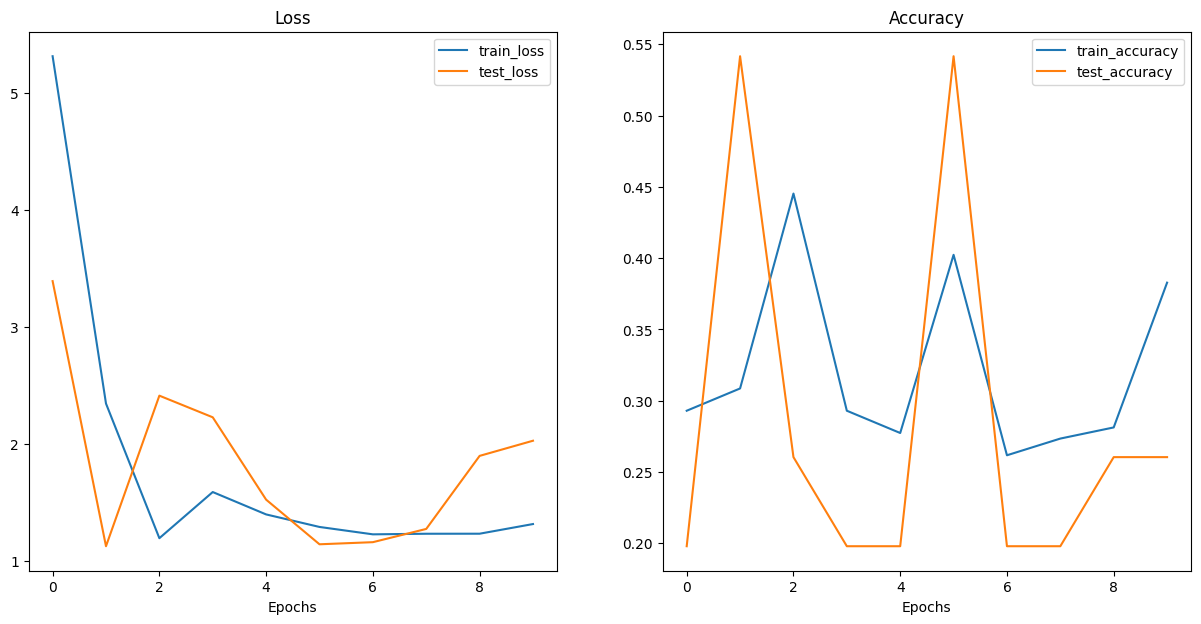

In [68]:
from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

## 10. Use a pretrainined ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.
If you can find a pretrained model and use transfer learning, give it a go, it often achives great results with little data

### 10.1 Why use a pretrained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

In [69]:
# Cost of a TPUv3 for 30 days
cost = 30*24*8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost}USD")

Cost of renting a TPUv3 for 30 straight days: $5760USD


In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [71]:
import torchvision

# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available params

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameters in pretrained_vit.parameters():
  parameters.requires_grad = False

# Update for classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 68.9MB/s]


### 10.2 Check Summary for ViT model

In [72]:
 # Get a summary using torchinfo.summary
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that model is trained on

In [73]:
# Get automatic transforms from pretrained vit model
automatic_transforms = pretrained_vit_weights.transforms()

automatic_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [74]:
# Turning data to data loaders
from modular.data_setup import create_dataloaders
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=automatic_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 10.4 Training pretrained_vit model

In [75]:
from modular.engine import train

# Create loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

set_seeds()
results = train(model=pretrained_vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7662 | train_acc: 0.7188 | test_loss: 0.5440 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3442 | train_acc: 0.9453 | test_loss: 0.3269 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2081 | train_acc: 0.9531 | test_loss: 0.2718 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1576 | train_acc: 0.9609 | test_loss: 0.2438 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1268 | train_acc: 0.9727 | test_loss: 0.2297 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1258 | train_acc: 0.9766 | test_loss: 0.2152 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0981 | train_acc: 0.9766 | test_loss: 0.2396 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0854 | train_acc: 0.9844 | test_loss: 0.2311 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1166 | train_acc: 0.9883 | test_loss: 0.2084 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0741 | train_acc: 0.9922 | test_loss: 0.1813 | test_acc: 0.9176


### 10.5 Plot Loss and accuracy for our pretrained vit model

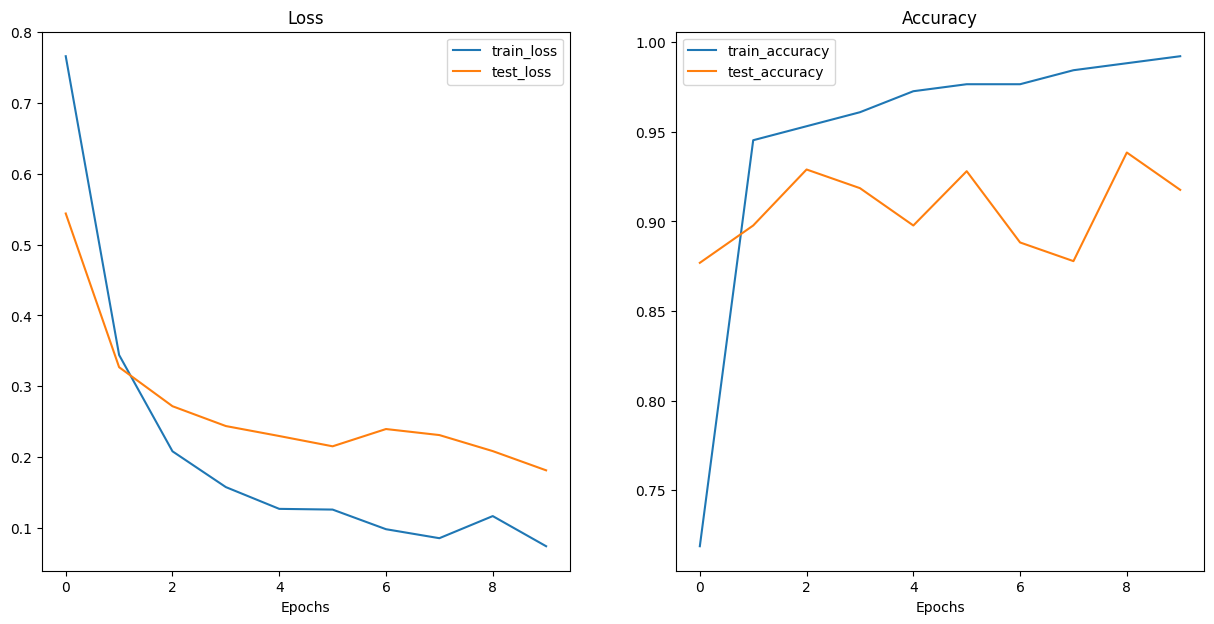

In [76]:
from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [77]:
# Save the model
from modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor.pth


In [78]:
from pathlib import Path

pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024)
print(f'Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB')

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file/might not make predictions as fast as a smaller model).

## 11. Predicting on a custom image

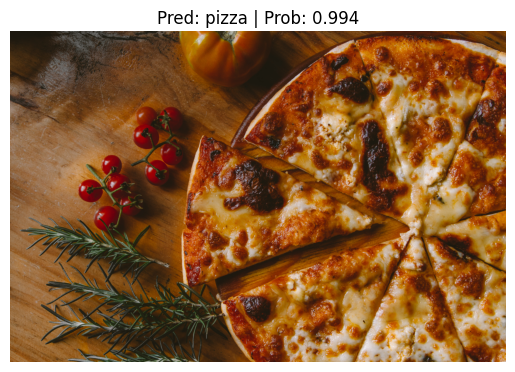

In [79]:
import requests

# Import function to make predictions on images and plot them
from modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = data_path / "random-pizza-img.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://images.unsplash.com/photo-1513104890138-7c749659a591")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)